### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [842]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.12f}'.format
np.set_printoptions(precision=12)
warnings.filterwarnings("ignore")

In [843]:
df = pd.read_csv("Cleaned1.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' , 'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'M0','Cus','Toe', 'Cic', 'OMEGA', 'e',
       'Cis', 'i0', 'omega', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,Crs,Del_n,Cuc,sqrt_A,Crc
Epoch_Time_of_Clock,,,,,
2017-11-01 14:00:00,20.718750000000,0.000000004875,0.000001013279,"5,153.670196530000",309.375000000000
2017-11-01 16:00:00,16.812500000000,0.000000004917,0.000000726432,"5,153.669187550000",310.125000000000
2017-11-01 18:00:00,13.843750000000,0.000000004875,0.000000702217,"5,153.669887540000",308.625000000000
2017-11-01 20:00:00,12.281250000000,0.000000004875,0.000000769272,"5,153.670305250000",309.375000000000
2017-11-01 22:00:00,23.031250000000,0.000000004753,0.000001149252,"5,153.673240660000",307.437500000000


In [844]:
df.columns

Index(['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc'], dtype='object')

# enter parameters and Satellite PRN

In [845]:
var_name = 'sqrt_A'
sat_var = 1

In [846]:
df = df.iloc[5 : , :]

In [847]:

df

,Crs,Del_n,Cuc,sqrt_A,Crc
Epoch_Time_of_Clock,,,,,
2017-11-02 12:00:00,40.031250000000,0.000000004919,0.000002089888,"5,153.672128680000",297.031250000000
2017-11-02 14:00:00,46.562500000000,0.000000004852,0.000002363697,"5,153.669368740000",288.656250000000
2017-11-02 16:00:00,43.843750000000,0.000000004891,0.000002117828,"5,153.668636320000",289.531250000000
2017-11-02 18:00:00,41.750000000000,0.000000004866,0.000002151355,"5,153.668607710000",290.937500000000
2017-11-02 20:00:00,38.531250000000,0.000000004865,0.000002132729,"5,153.669593810000",293.375000000000
2017-11-02 22:00:00,47.281250000000,0.000000004740,0.000002415851,"5,153.672065730000",289.593750000000
2017-11-03 12:00:00,53.625000000000,0.000000004826,0.000002810732,"5,153.673458100000",266.281250000000
2017-11-03 14:00:00,58.187500000000,0.000000004746,0.000002987683,"5,153.670349120000",255.406250000000
2017-11-03 16:00:00,55.843750000000,0.000000004778,0.000002736226,"5,153.669727330000",254.875000000000


# Enter number of entries per day

In [848]:
entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))

168
2017-11-25 12:00:00 2017-11-21 12:00:00
<class 'str'>



Load data into Pandas dataframe

# enter lag and no. of outputs

In [849]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 6
HORIZON = 6

Create training set containing only the model features

In [850]:
train = df.copy()[df.index < valid_start_dt][['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc' ]]
train.head()

,Crs,Del_n,Cuc,sqrt_A,Crc
Epoch_Time_of_Clock,,,,,
2017-11-02 12:00:00,40.031250000000,0.000000004919,0.000002089888,"5,153.672128680000",297.031250000000
2017-11-02 14:00:00,46.562500000000,0.000000004852,0.000002363697,"5,153.669368740000",288.656250000000
2017-11-02 16:00:00,43.843750000000,0.000000004891,0.000002117828,"5,153.668636320000",289.531250000000
2017-11-02 18:00:00,41.750000000000,0.000000004866,0.000002151355,"5,153.668607710000",290.937500000000
2017-11-02 20:00:00,38.531250000000,0.000000004865,0.000002132729,"5,153.669593810000",293.375000000000


In [851]:
train.tail(6)

,Crs,Del_n,Cuc,sqrt_A,Crc
Epoch_Time_of_Clock,,,,,
2017-11-20 12:00:00,-20.406250000000,0.000000004216,-0.000001039356,"5,153.679801940000",169.656250000000
2017-11-20 14:00:00,-14.062500000000,0.000000004161,-0.000000858679,"5,153.680685040000",168.312500000000
2017-11-20 16:00:00,-13.000000000000,0.000000004202,-0.000000847504,"5,153.677953720000",179.531250000000
2017-11-20 18:00:00,-23.156250000000,0.000000004186,-0.000001130626,"5,153.681100850000",187.562500000000
2017-11-20 20:00:00,-30.343750000000,0.000000004166,-0.000001562759,"5,153.679851530000",188.250000000000
2017-11-20 22:00:00,-34.812500000000,0.000000004077,-0.000001810491,"5,153.682205200000",178.343750000000


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [853]:
from sklearn.preprocessing import StandardScaler




y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()

train[['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc']] = X_scaler.fit_transform(train)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [854]:
tensor_structure = {'X':(range(-T+1, 1), ['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc'])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), ['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc'])} ,freq = None)

In [855]:
train_inputs.dataframe

tensor                       target                                  \
feature                           y                                   
time step                       t+1             t+2             t+3   
Epoch_Time_of_Clock                                                   
2017-11-02 22:00:00 -0.675754723574 -1.426387417839 -1.576512508022   
2017-11-03 12:00:00 -1.426387417839 -1.576512508022 -1.708220541186   
2017-11-03 14:00:00 -1.576512508022 -1.708220541186 -1.398295852747   
2017-11-03 16:00:00 -1.708220541186 -1.398295852747 -0.986138148336   
2017-11-03 18:00:00 -1.398295852747 -0.986138148336 -0.156759739101   
2017-11-03 20:00:00 -0.986138148336 -0.156759739101 -0.777987739546   
2017-11-03 22:00:00 -0.156759739101 -0.777987739546 -0.999953355422   
2017-11-04 12:00:00 -0.777987739546 -0.999953355422 -1.044163467163   
2017-11-04 14:00:00 -0.999953355422 -1.044163467163 -0.788579720265   
2017-11-04 16:00:00 -1.044163467163 -0.788579720265 -0.544049104567   
2017-11-04 18:00:00 -0.788579720265 -0.544049104567  0.409668583260   
2017-11-04 20:00:00 -0.544049104567  0.409668583260  0.106651498474   
2017-11-04 22:00:00  0.409668583260  0.106651498474 -0.297215150184   
2017-11-05 12:00:00  0.106651498474 -0.297215150184 -0.005251196818   
2017-11-05 14:00:00 -0.297215150184 -0.005251196818  0.068429103362   
2017-11-05 16:00:00 -0.005251196818  0.068429103362  0.259541078700   
2017-11-05 18:00:00  0.068429103362  0.259541078700  0.873863889868   
2017-11-05 20:00:00  0.259541078700  0.873863889868  0.972412528554   
2017-11-05 22:00:00  0.873863889868  0.972412528554  0.331381604613   
2017-11-06 12:00:00  0.972412528554  0.331381604613  1.056226072910   
2017-11-06 14:00:00  0.331381604613  1.056226072910  0.898729813998   
2017-11-06 16:00:00  1.056226072910  0.898729813998  1.184708465331   
2017-11-06 18:00:00  0.898729813998  1.184708465331  1.140039617486   
2017-11-06 20:00:00  1.184708465331  1.140039617486  1.594562830398   
2017-11-06 22:00:00  1.140039617486  1.594562830398  0.752289101100   
2017-11-07 12:00:00  1.594562830398  0.752289101100  1.762648655654   
2017-11-07 14:00:00  0.752289101100  1.762648655654  1.434304495819   
2017-11-07 16:00:00  1.762648655654  1.434304495819  1.900341990851   
2017-11-07 18:00:00  1.434304495819  1.900341990851  1.169512220301   
2017-11-07 20:00:00  1.900341990851  1.169512220301  1.838632294958   
...                             ...             ...             ...   
2017-11-15 12:00:00 -1.223763574538 -0.862262434602 -0.758645966530   
2017-11-15 14:00:00 -0.862262434602 -0.758645966530 -1.034952524167   
2017-11-15 16:00:00 -0.758645966530 -1.034952524167 -0.944231376158   
2017-11-15 18:00:00 -1.034952524167 -0.944231376158 -1.171264821641   
2017-11-15 20:00:00 -0.944231376158 -1.171264821641 -1.072716182955   
2017-11-15 22:00:00 -1.171264821641 -1.072716182955 -0.827263266077   
2017-11-16 12:00:00 -1.072716182955 -0.827263266077 -0.396224939570   
2017-11-16 14:00:00 -0.827263266077 -0.396224939570 -0.766937022283   
2017-11-16 16:00:00 -0.396224939570 -0.766937022283 -0.544968991810   
2017-11-16 18:00:00 -0.766937022283 -0.544968991810 -0.826802115377   
2017-11-16 20:00:00 -0.544968991810 -0.826802115377 -0.675293572874   
2017-11-16 22:00:00 -0.826802115377 -0.675293572874 -0.645820969839   
2017-11-17 12:00:00 -0.675293572874 -0.645820969839  0.049548481266   
2017-11-17 14:00:00 -0.645820969839  0.049548481266 -0.380106393141   
2017-11-17 16:00:00  0.049548481266 -0.380106393141  0.005340784121   
2017-11-17 18:00:00 -0.380106393141  0.005340784121 -0.311030357270   
2017-11-17 20:00:00  0.005340784121 -0.311030357270 -0.108406514189   
2017-11-17 22:00:00 -0.311030357270 -0.108406514189 -0.341425261705   
2017-11-18 12:00:00 -0.108406514189 -0.341425261705  0.501309618293   
2017-11-18 14:00:00 -0.341425261705  0.501309618293  0.062904952029   
2017-11-18 16:00:00  0.501309618293  0.062904952029  0.581438785582   
2017-11-18 18:00:00  0.0

In [856]:
train_inputs['target'].shape

(103, 6)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [857]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc']]
valid[['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                      target                                \
feature                          y                                 
time step                      t+1            t+2            t+3   
Epoch_Time_of_Clock                                                
2017-11-21 22:00:00 1.575682208083 1.632785225290 0.964585037877   
2017-11-22 12:00:00 1.632785225290 0.964585037877 1.335294706214   
2017-11-22 14:00:00 0.964585037877 1.335294706214 1.321018348428   
2017-11-22 16:00:00 1.335294706214 1.321018348428 1.564629076663   
2017-11-22 18:00:00 1.321018348428 1.564629076663 1.600548132432   

tensor                                                            \
feature                                                            
time step                      t+4            t+5            t+6   
Epoch_Time_of_Clock                                                
2017-11-21 22:00:00 1.335294706214 1.321018348428 1.564629076663   
2017-11-22 12:00:00 1.321018348428 1.564629076663 1.600548132432   
2017-11-22 14:00:00 1.564629076663 1.600548132432 1.540683039558   
2017-11-22 16:00:00 1.600548132432 1.540683039558 1.040568677181   
2017-11-22 18:00:00 1.540683039558 1.040568677181 1.210957841780   

tensor                            X                                  \
feature                         Crs                                   
time step                       t-5             t-4             t-3   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -0.831490137645 -0.696781952217 -0.617770420379   
2017-11-22 12:00:00 -0.696781952217 -0.617770420379 -0.748592792766   
2017-11-22 14:00:00 -0.617770420379 -0.748592792766 -0.878119894139   
2017-11-22 16:00:00 -0.748592792766 -0.878119894139 -1.012180444061   
2017-11-22 18:00:00 -0.878119894139 -1.012180444061 -1.296492431575   

tensor                               ...                                \
feature                              ...         sqrt_A                  
time step                       t-2  ...            t-3            t-2   
Epoch_Time_of_Clock                  ...                                 
2017-11-21 22:00:00 -0.748592792766  ... 0.736631705371 1.317795121842   
2017-11-22 12:00:00 -0.878119894139  ... 1.317795121842 1.150170447505   
2017-11-22 14:00:00 -1.012180444061  ... 1.150170447505 1.602390321075   
2017-11-22 16:00:00 -1.296492431575  ... 1.602390321075 1.575682208083   
2017-11-22 18:00:00 -1.182508582367  ... 1.575682208083 1.632785225290   

tensor                                                             \
feature                                                       Crc   
time step                      t-1              t             t-5   
Epoch_Time_of_Clock                                                 
2017-11-21 22:00:00 1.150170447505 1.602390321075 -1.309345089183   
2017-11-22 12:00:00 1.602390321075 1.575682208083 -1.388611127929   
2017-11-22 14:00:00 1.575682208083 1.632785225290 -1.119912691500   
2017-11-22 16:00:00 1.632785225290 0.964585037877 -0.912343149359   
2017-11-22 18:00:00 0.964585037877 1.335294706214 -0.841138063705   

tensor                                                               \
feature                                                               
time step                       t-4             t-3             t-2   
Epoch_Time_of_Clock                                                   
2017-11-21 22:00:00 -1.388611127929 -1.119912691500 -0.912343149359   
2017-11-22 12:00:00 -1.119912691500 -0.912343149359 -0.841138063705   
2017-11-22 14:00:00 -0.912343149359 -0.841138063705 -1.009746332564   
2017-11-22 16:00:00 -0.841138063705 -1.009746332564 -1.069531734670   
2017-11-22 18:00:00 -1.009746332564 -1.069531734670 -1.195819999791   

tensor                                               
feature                                              
time step                       t-1               t  
Epoch_Time_of_Clock                        

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [858]:
#Image('./images/simple_encoder_decoder.png')

In [859]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [860]:
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS = 1000

In [861]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,5 ) , return_sequences = True))
model.add(LSTM(LATENT_DIM))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [862]:
model.compile(optimizer='RMSprop', loss='mse')

In [863]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 6, 64)             17920     
_________________________________________________________________
lstm_40 (LSTM)               (None, 64)                33024     
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 6, 64)             0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 6, 64)             33024     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 6, 1)              65        
_________________________________________________________________
flatten_16 (Flatten)         (None, 6)                 0         
Total params: 84,033
Trainable params: 84,033
Non-trainable params: 0
_________________________________________________________________


In [864]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [865]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [866]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 103 samples, validate on 13 samples
Epoch 1/1000
103/103 [==============================] - 8s 74ms/step - loss: 0.7986 - val_loss: 0.5718
Epoch 2/1000
103/103 [==============================] - 0s 668us/step - loss: 0.4011 - val_loss: 0.2746
Epoch 3/1000
103/103 [==============================] - 0s 717us/step - loss: 0.2360 - val_loss: 0.3060
Epoch 4/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.2064 - val_loss: 0.3007
Epoch 5/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1978 - val_loss: 0.2732
Epoch 6/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1848 - val_loss: 0.2587
Epoch 7/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.1749 - val_loss: 0.2504
Epoch 8/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.1643 - val_loss: 0.2418
Epoch 9/1000
103/103 [==============================] - 0s 898us/step - loss: 0.1554 - val_loss: 0.2425
Epoch 10/1000
103/103 [=======

Epoch 80/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0965 - val_loss: 0.0472
Epoch 81/1000
103/103 [==============================] - 0s 836us/step - loss: 0.0934 - val_loss: 0.0525
Epoch 82/1000
103/103 [==============================] - 0s 850us/step - loss: 0.0935 - val_loss: 0.0420
Epoch 83/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0918 - val_loss: 0.0555
Epoch 84/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0931 - val_loss: 0.0456
Epoch 85/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0959 - val_loss: 0.0770
Epoch 86/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0928 - val_loss: 0.0681
Epoch 87/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0956 - val_loss: 0.0982
Epoch 88/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0904 - val_loss: 0.1030
Epoch 89/1000
103/103 [==============================] - 0s 1ms/step 

103/103 [==============================] - 0s 1ms/step - loss: 0.0849 - val_loss: 0.0612
Epoch 159/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0848 - val_loss: 0.0648
Epoch 160/1000
103/103 [==============================] - 0s 914us/step - loss: 0.0842 - val_loss: 0.0583
Epoch 161/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0849 - val_loss: 0.0639
Epoch 162/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0798 - val_loss: 0.0589
Epoch 163/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0803 - val_loss: 0.0714
Epoch 164/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0804 - val_loss: 0.0647
Epoch 165/1000
103/103 [==============================] - 0s 971us/step - loss: 0.0897 - val_loss: 0.0650
Epoch 166/1000
103/103 [==============================] - 0s 850us/step - loss: 0.0861 - val_loss: 0.0735
Epoch 167/1000
103/103 [==============================] - 0s 853us/step -

103/103 [==============================] - 0s 1ms/step - loss: 0.0768 - val_loss: 0.0585
Epoch 237/1000
103/103 [==============================] - 0s 773us/step - loss: 0.0742 - val_loss: 0.0671
Epoch 238/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0742 - val_loss: 0.0676
Epoch 239/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0789 - val_loss: 0.0663
Epoch 240/1000
103/103 [==============================] - 0s 992us/step - loss: 0.0826 - val_loss: 0.0544
Epoch 241/1000
103/103 [==============================] - 0s 993us/step - loss: 0.0807 - val_loss: 0.0619
Epoch 242/1000
103/103 [==============================] - 0s 825us/step - loss: 0.0796 - val_loss: 0.0549
Epoch 243/1000
103/103 [==============================] - 0s 809us/step - loss: 0.0789 - val_loss: 0.0722
Epoch 244/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0770 - val_loss: 0.0764
Epoch 245/1000
103/103 [==============================] - 0s 869us/st

103/103 [==============================] - 0s 901us/step - loss: 0.0706 - val_loss: 0.2012
Epoch 315/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.2116
Epoch 316/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.1496
Epoch 317/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.1238
Epoch 318/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0718 - val_loss: 0.3534
Epoch 319/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.3025
Epoch 320/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0758
Epoch 321/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.2425
Epoch 322/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.1319
Epoch 323/1000
103/103 [==============================] - 0s 2ms/step - loss:

Epoch 393/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.1497
Epoch 394/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.1654
Epoch 395/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.1810
Epoch 396/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0559 - val_loss: 0.1700
Epoch 397/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0540 - val_loss: 0.1677
Epoch 398/1000
103/103 [==============================] - 0s 953us/step - loss: 0.0522 - val_loss: 0.1822
Epoch 399/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0576 - val_loss: 0.1937
Epoch 400/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0575 - val_loss: 0.1978
Epoch 401/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0528 - val_loss: 0.2367
Epoch 402/1000
103/103 [==============================] - 0s 7

103/103 [==============================] - 0s 1ms/step - loss: 0.0494 - val_loss: 0.1299
Epoch 472/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0517 - val_loss: 0.1743
Epoch 473/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0522 - val_loss: 0.2023
Epoch 474/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.1522
Epoch 475/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.1519
Epoch 476/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.1048
Epoch 477/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0489 - val_loss: 0.1991
Epoch 478/1000
103/103 [==============================] - 0s 680us/step - loss: 0.0481 - val_loss: 0.1266
Epoch 479/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0488 - val_loss: 0.2051
Epoch 480/1000
103/103 [==============================] - 0s 1ms/step - loss:

Epoch 550/1000
103/103 [==============================] - 0s 1ms/step - loss: 0.0374 - val_loss: 0.1421
Epoch 551/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.1753
Epoch 552/1000
103/103 [==============================] - 0s 3ms/step - loss: 0.0575 - val_loss: 0.1654
Epoch 553/1000
103/103 [==============================] - 0s 3ms/step - loss: 0.0426 - val_loss: 0.2204
Epoch 554/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.1562
Epoch 555/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.1617
Epoch 556/1000
103/103 [==============================] - 0s 3ms/step - loss: 0.0438 - val_loss: 0.1337
Epoch 557/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.1922
Epoch 558/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.1608
Epoch 559/1000
103/103 [==============================] - 0s 2ms

Epoch 628/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.1399
Epoch 629/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.1192
Epoch 630/1000
103/103 [==============================] - 0s 446us/step - loss: 0.0392 - val_loss: 0.1918
Epoch 631/1000
103/103 [==============================] - 0s 440us/step - loss: 0.0393 - val_loss: 0.1790
Epoch 632/1000
103/103 [==============================] - 0s 429us/step - loss: 0.0284 - val_loss: 0.1544
Epoch 633/1000
103/103 [==============================] - 0s 504us/step - loss: 0.0288 - val_loss: 0.1411
Epoch 634/1000
103/103 [==============================] - 0s 512us/step - loss: 0.0321 - val_loss: 0.1755
Epoch 635/1000
103/103 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.1469
Epoch 636/1000
103/103 [==============================] - 0s 659us/step - loss: 0.0306 - val_loss: 0.1617
Epoch 637/1000
103/103 [============================

103/103 [==============================] - 0s 453us/step - loss: 0.0256 - val_loss: 0.1357
Epoch 706/1000
103/103 [==============================] - 0s 462us/step - loss: 0.0243 - val_loss: 0.2083
Epoch 707/1000
103/103 [==============================] - 0s 451us/step - loss: 0.0216 - val_loss: 0.1141
Epoch 708/1000
103/103 [==============================] - 0s 476us/step - loss: 0.0261 - val_loss: 0.2058
Epoch 709/1000
103/103 [==============================] - 0s 470us/step - loss: 0.0265 - val_loss: 0.1782
Epoch 710/1000
103/103 [==============================] - 0s 477us/step - loss: 0.0308 - val_loss: 0.1877
Epoch 711/1000
103/103 [==============================] - 0s 472us/step - loss: 0.0239 - val_loss: 0.1864
Epoch 712/1000
103/103 [==============================] - 0s 454us/step - loss: 0.0266 - val_loss: 0.1689
Epoch 713/1000
103/103 [==============================] - 0s 454us/step - loss: 0.0247 - val_loss: 0.1600
Epoch 714/1000
103/103 [==============================] - 0s 

103/103 [==============================] - 0s 462us/step - loss: 0.0250 - val_loss: 0.1504
Epoch 783/1000
103/103 [==============================] - 0s 464us/step - loss: 0.0172 - val_loss: 0.1663
Epoch 784/1000
103/103 [==============================] - 0s 457us/step - loss: 0.0172 - val_loss: 0.1346
Epoch 785/1000
103/103 [==============================] - 0s 458us/step - loss: 0.0180 - val_loss: 0.2148
Epoch 786/1000
103/103 [==============================] - 0s 508us/step - loss: 0.0182 - val_loss: 0.1616


In [752]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

In [754]:
 model.fit(valid_inputs['X'],
          valid_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=100,
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Epoch 1/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0345
Epoch 2/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0427
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0410
Epoch 4/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0474
Epoch 5/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0406
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0339
Epoch 7/100
13/13 [==============================] - 0s 1ms/step - loss: 0.0332
Epoch 8/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0333
Epoch 9/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0306
Epoch 10/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0297
Epoch 11/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0292
Epoch 12/100
13/13 [==============================] - 0s 2ms/step - loss: 0.0293
Epoch 13/100
13/13 [=================

## Evaluate the model

In [867]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc']]
test[['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                      target                                 \
feature                          y                                  
time step                      t+1            t+2             t+3   
Epoch_Time_of_Clock                                                 
2017-11-25 22:00:00 0.329539415970 0.018233689588  0.201057023550   
2017-11-26 12:00:00 0.018233689588 0.201057023550  0.145796194985   
2017-11-26 14:00:00 0.201057023550 0.145796194985  0.744459196048   
2017-11-26 16:00:00 0.145796194985 0.744459196048  0.112178064184   
2017-11-26 18:00:00 0.744459196048 0.112178064184 -0.327148903700   

tensor                                                               \
feature                                                               
time step                       t+4             t+5             t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  0.145796194985  0.744459196048  0.112178064184   
2017-11-26 12:00:00  0.744459196048  0.112178064184 -0.327148903700   
2017-11-26 14:00:00  0.112178064184 -0.327148903700 -0.628321385686   
2017-11-26 16:00:00 -0.327148903700 -0.628321385686 -0.366752336535   
2017-11-26 18:00:00 -0.628321385686 -0.366752336535 -0.332675469409   

tensor                            X                                  \
feature                         Crs                                   
time step                       t-5             t-4             t-3   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -1.536117569116 -1.573680428514 -1.448686775689   
2017-11-26 12:00:00 -1.573680428514 -1.448686775689 -1.355427262700   
2017-11-26 14:00:00 -1.448686775689 -1.355427262700 -1.253748488122   
2017-11-26 16:00:00 -1.355427262700 -1.253748488122 -1.280301543903   
2017-11-26 18:00:00 -1.253748488122 -1.280301543903 -1.169555872229   

tensor                               ...                                \
feature                              ...         sqrt_A                  
time step                       t-2  ...            t-3            t-2   
Epoch_Time_of_Clock                  ...                                 
2017-11-25 22:00:00 -1.355427262700  ... 0.654660349438 0.593411804245   
2017-11-26 12:00:00 -1.253748488122  ... 0.593411804245 1.071883468639   
2017-11-26 14:00:00 -1.280301543903  ... 1.071883468639 0.549662843424   
2017-11-26 16:00:00 -1.169555872229  ... 0.549662843424 0.329539415970   
2017-11-26 18:00:00 -1.245976862040  ... 0.329539415970 0.018233689588   

tensor                                                            \
feature                                                      Crc   
time step                      t-1              t            t-5   
Epoch_Time_of_Clock                                                
2017-11-25 22:00:00 1.071883468639 0.549662843424 0.428462048423   
2017-11-26 12:00:00 0.549662843424 0.329539415970 0.285380131024   
2017-11-26 14:00:00 0.329539415970 0.018233689588 0.274632193567   
2017-11-26 16:00:00 0.018233689588 0.201057023550 0.373378868955   
2017-11-26 18:00:00 0.201057023550 0.145796194985 0.528552215992   

tensor                                                            \
feature                                                            
time step                      t-4            t-3            t-2   
Epoch_Time_of_Clock                                                
2017-11-25 22:00:00 0.285380131024 0.274632193567 0.373378868955   
2017-11-26 12:00:00 0.274632193567 0.373378868955 0.528552215992   
2017-11-26 14:00:00 0.373378868955 0.528552215992 0.709923660582   
2017-11-26 16:00:00 0.528552215992 0.709923660582 0.899356058265   
2017-11-26 18:00:00 0.709923660582 0.899356058265 0.798594144604   

tensor                                             
feature                                            
time step                      t-1              t  
Epoch_Time_of_Clock                              

In [868]:
test_inputs.dataframe.head(50)

tensor                       target                                  \
feature                           y                                   
time step                       t+1             t+2             t+3   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  0.329539415970  0.018233689588  0.201057023550   
2017-11-26 12:00:00  0.018233689588  0.201057023550  0.145796194985   
2017-11-26 14:00:00  0.201057023550  0.145796194985  0.744459196048   
2017-11-26 16:00:00  0.145796194985  0.744459196048  0.112178064184   
2017-11-26 18:00:00  0.744459196048  0.112178064184 -0.327148903700   
2017-11-26 20:00:00  0.112178064184 -0.327148903700 -0.628321385686   
2017-11-26 22:00:00 -0.327148903700 -0.628321385686 -0.366752336535   
2017-11-27 12:00:00 -0.628321385686 -0.366752336535 -0.332675469409   
2017-11-27 14:00:00 -0.366752336535 -0.332675469409  0.327697227327   
2017-11-27 16:00:00 -0.332675469409  0.327697227327 -0.242415472100   
2017-11-27 18:00:00  0.327697227327 -0.242415472100 -0.903708056080   
2017-11-27 20:00:00 -0.242415472100 -0.903708056080 -1.147318784535   
2017-11-27 22:00:00 -0.903708056080 -1.147318784535 -0.947457016901   
2017-11-28 12:00:00 -1.147318784535 -0.947457016901 -0.764172532240   
2017-11-28 14:00:00 -0.947457016901 -0.764172532240 -0.113933079899   
2017-11-28 16:00:00 -0.764172532240 -0.113933079899 -0.424777655362   
2017-11-28 18:00:00 -0.113933079899 -0.424777655362 -1.241721895234   
2017-11-28 20:00:00 -0.424777655362 -1.241721895234 -1.410268871190   
2017-11-28 22:00:00 -1.241721895234 -1.410268871190 -1.375730853365   

tensor                                                               \
feature                                                               
time step                       t+4             t+5             t+6   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00  0.145796194985  0.744459196048  0.112178064184   
2017-11-26 12:00:00  0.744459196048  0.112178064184 -0.327148903700   
2017-11-26 14:00:00  0.112178064184 -0.327148903700 -0.628321385686   
2017-11-26 16:00:00 -0.327148903700 -0.628321385686 -0.366752336535   
2017-11-26 18:00:00 -0.628321385686 -0.366752336535 -0.332675469409   
2017-11-26 20:00:00 -0.366752336535 -0.332675469409  0.327697227327   
2017-11-26 22:00:00 -0.332675469409  0.327697227327 -0.242415472100   
2017-11-27 12:00:00  0.327697227327 -0.242415472100 -0.903708056080   
2017-11-27 14:00:00 -0.242415472100 -0.903708056080 -1.147318784535   
2017-11-27 16:00:00 -0.903708056080 -1.147318784535 -0.947457016901   
2017-11-27 18:00:00 -1.147318784535 -0.947457016901 -0.764172532240   
2017-11-27 20:00:00 -0.947457016901 -0.764172532240 -0.113933079899   
2017-11-27 22:00:00 -0.764172532240 -0.113933079899 -0.424777655362   
2017-11-28 12:00:00 -0.113933079899 -0.424777655362 -1.241721895234   
2017-11-28 14:00:00 -0.424777655362 -1.241721895234 -1.410268871190   
2017-11-28 16:00:00 -1.241721895234 -1.410268871190 -1.375730853365   
2017-11-28 18:00:00 -1.410268871190 -1.375730853365 -1.031268147101   
2017-11-28 20:00:00 -1.375730853365 -1.031268147101 -0.481419521869   
2017-11-28 22:00:00 -1.031268147101 -0.481419521869 -0.379647656817   

tensor                            X                                  \
feature                         Crs                                   
time step                       t-5             t-4             t-3   
Epoch_Time_of_Clock                                                   
2017-11-25 22:00:00 -1.536117569116 -1.573680428514 -1.448686775689   
2017-11-26 12:00:00 -1.573680428514 -1.448686775689 -1.355427262700   
2017-11-26 14:00:00 -1.448686775689 -1.355427262700 -1.253748488122   
2017-11-26 16:00:00 -1.355427262700 -1.253748488122 -1.280301543903   
2017-11-26 18:00:00 -1.253748488122 -1.280301543903 -1.169555872229   
2017-11-26 20:00:00 -1.280301543903 -1.169555872229 -1.245976862040   
2017-11-26 22:00:00 -1

In [869]:
test_inputs.dataframe.shape

(19, 36)

In [870]:
predictions = model.predict(test_inputs['X'])

In [871]:
predictions

array([[ 3.9523295e-01,  6.4525291e-02,  3.2252744e-01,  9.2291608e-02,
         1.6125304e-01, -2.1307507e-01],
       [ 7.9024777e-02,  2.7002031e-01,  2.2530787e-01,  2.2932312e-01,
         3.6219660e-02, -8.3716959e-04],
       [ 1.8830797e-01,  2.1658339e-02,  2.0841354e-01,  9.5799221e-03,
         3.1525005e-02, -3.2365134e-01],
       [ 2.1434596e-01, -1.4544243e-01,  8.8306025e-02, -8.8593751e-02,
        -9.2784688e-02, -4.2568845e-01],
       [ 2.3696394e-01, -2.6540101e-01, -2.4137467e-02, -1.7427079e-01,
        -2.1514784e-01, -4.9797401e-01],
       [ 1.1172703e-01, -3.2287627e-01, -1.6391514e-01, -3.1983590e-01,
        -3.6314633e-01, -5.6551820e-01],
       [-1.7033124e-01, -2.7541885e-01, -2.6643953e-01, -3.3307067e-01,
        -4.1832441e-01, -5.3394133e-01],
       [-4.5704946e-01, -2.4091789e-01, -1.7643741e-01, -2.3838881e-01,
        -3.1392372e-01, -3.8005587e-01],
       [-3.4611124e-01, -2.9084399e-01, -3.3835796e-01, -3.2544938e-01,
        -5.0555503e-01, 

In [872]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h         prediction             actual
0 2017-11-25 22:00:00  t+1 5,153.677893930293 5,153.677621840000
1 2017-11-26 12:00:00  t+1 5,153.676584255295 5,153.676332470000
2 2017-11-26 14:00:00  t+1 5,153.677036885812 5,153.677089690000
3 2017-11-26 16:00:00  t+1 5,153.677144730293 5,153.676860810000
4 2017-11-26 18:00:00  t+1 5,153.677238409732 5,153.679340360000
              timestamp    h         prediction             actual
109 2017-11-28 14:00:00  t+6 5,153.672710245438 5,153.670415880000
110 2017-11-28 16:00:00  t+6 5,153.672251633662 5,153.670558930000
111 2017-11-28 18:00:00  t+6 5,153.671407625465 5,153.671985630000
112 2017-11-28 20:00:00  t+6 5,153.671865995307 5,153.674263000000
113 2017-11-28 22:00:00  t+6 5,153.674143672377 5,153.674684520000
(114, 4)


In [873]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.000000108677
t+2   0.000000222641
t+3   0.000000243685
t+4   0.000000222390
t+5   0.000000249938
t+6   0.000000306738
Name: APE, dtype: float64

# prediction result

In [874]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

0.001163070432731298

In [875]:
eval_df['prediction']

0     5,153.677893930293
1     5,153.676584255295
2     5,153.677036885812
3     5,153.677144730293
4     5,153.677238409732
5     5,153.676719701897
6     5,153.675551469387
7     5,153.674363936234
8     5,153.674823421564
9     5,153.675021721778
10    5,153.675562285496
11    5,153.675239040091
12    5,153.673119515299
13    5,153.672353213044
14    5,153.672499795084
15    5,153.672919715219
16    5,153.674262899475
17    5,153.674264680158
18    5,153.671590270706
19    5,153.676524201142
20    5,153.677375322997
21    5,153.676346654254
22    5,153.675654554190
23    5,153.675157708226
24    5,153.674919656430
25    5,153.675116216201
26    5,153.675259112700
27    5,153.675052328137
28    5,153.674472311982
29    5,153.673905329766
             ...        
84    5,153.674163035232
85    5,153.673800500817
86    5,153.673403249884
87    5,153.672772367384
88    5,153.673496230739
89    5,153.673864365675
90    5,153.673063424912
91    5,153.672024953744
92    5,153.671901852372


Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

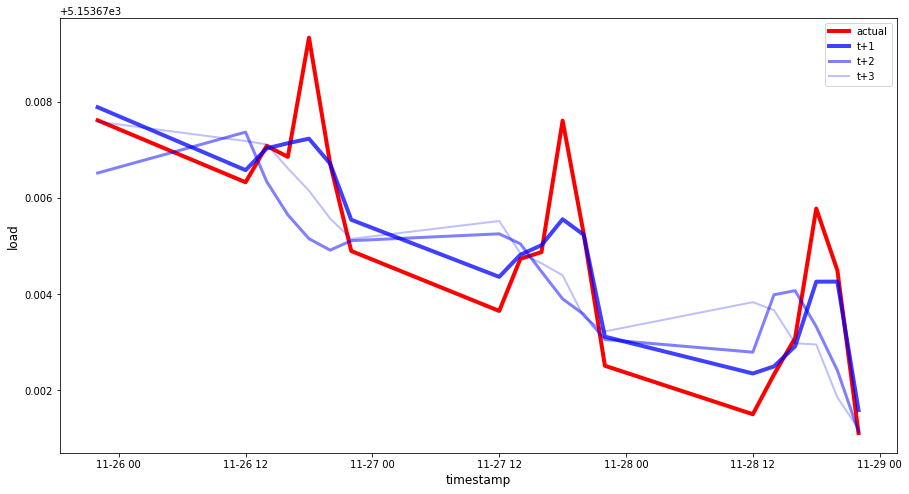

In [876]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [877]:
a = df.iloc[156:162  , :]
a

,Crs,Del_n,Cuc,sqrt_A,Crc
Epoch_Time_of_Clock,,,,,
2017-11-28 12:00:00,-7.843750000000,0.000000004682,-0.000000456348,"5,153.672513960000",288.250000000000
2017-11-28 14:00:00,-11.718750000000,0.000000004718,-0.000000722706,"5,153.671504970000",287.781250000000
2017-11-28 16:00:00,-14.062500000000,0.000000004688,-0.000000778586,"5,153.672332760000",285.187500000000
2017-11-28 18:00:00,-16.187500000000,0.000000004695,-0.000000737607,"5,153.673091890000",286.968750000000
2017-11-28 20:00:00,-6.312500000000,0.000000004596,-0.000000370666,"5,153.675785060000",287.531250000000
2017-11-28 22:00:00,-0.562500000000,0.000000004587,-0.000000091270,"5,153.674497600000",290.468750000000


In [878]:
new_df = pd.DataFrame()

In [879]:
columns = ['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc' ] 

In [880]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [881]:
new_df = new_df.dropna( how = 'any')

In [882]:
new_df

,Crs,Del_n,Cuc,sqrt_A,Crc
Epoch_Time_of_Clock,,,,,
2017-11-28 12:00:00,-7.843750000000,0.000000004682,-0.000000456348,"5,153.672513960000",288.250000000000
2017-11-28 14:00:00,-11.718750000000,0.000000004718,-0.000000722706,"5,153.671504970000",287.781250000000
2017-11-28 16:00:00,-14.062500000000,0.000000004688,-0.000000778586,"5,153.672332760000",285.187500000000
2017-11-28 18:00:00,-16.187500000000,0.000000004695,-0.000000737607,"5,153.673091890000",286.968750000000
2017-11-28 20:00:00,-6.312500000000,0.000000004596,-0.000000370666,"5,153.675785060000",287.531250000000
2017-11-28 22:00:00,-0.562500000000,0.000000004587,-0.000000091270,"5,153.674497600000",290.468750000000


In [883]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 29)

In [884]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [885]:
date

DatetimeIndex(['2017-11-29 12:00:00', '2017-11-29 14:00:00',
               '2017-11-29 16:00:00', '2017-11-29 18:00:00',
               '2017-11-29 20:00:00', '2017-11-29 22:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='2H')

In [886]:
new_df.index= date

In [887]:
new_df.columns

Index(['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc'], dtype='object')

In [888]:
print(new_df)
print(new_df.columns)

                                 Crs          Del_n             Cuc  \
Epoch_Time_of_Clock                                                   
2017-11-29 12:00:00  -7.843750000000 0.000000004682 -0.000000456348   
2017-11-29 14:00:00 -11.718750000000 0.000000004718 -0.000000722706   
2017-11-29 16:00:00 -14.062500000000 0.000000004688 -0.000000778586   
2017-11-29 18:00:00 -16.187500000000 0.000000004695 -0.000000737607   
2017-11-29 20:00:00  -6.312500000000 0.000000004596 -0.000000370666   
2017-11-29 22:00:00  -0.562500000000 0.000000004587 -0.000000091270   

                                sqrt_A              Crc  
Epoch_Time_of_Clock                                      
2017-11-29 12:00:00 5,153.672513960000 288.250000000000  
2017-11-29 14:00:00 5,153.671504970000 287.781250000000  
2017-11-29 16:00:00 5,153.672332760000 285.187500000000  
2017-11-29 18:00:00 5,153.673091890000 286.968750000000  
2017-11-29 20:00:00 5,153.675785060000 287.531250000000  
2017-11-29 22:00:00 5,153

In [889]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc']] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), ['Crs', 'Del_n', 'Cuc', 'sqrt_A', 'Crc'])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                Crs          Del_n             Cuc  \
Epoch_Time_of_Clock                                                  
2017-11-29 12:00:00 -0.017412305514 0.912690277182 -0.026884544478   
2017-11-29 14:00:00 -0.097719108365 1.077670868243 -0.133261205663   
2017-11-29 16:00:00 -0.146291771380 0.939920083469 -0.155577987730   
2017-11-29 18:00:00 -0.190330985847 0.971955149724 -0.139212347547   
2017-11-29 20:00:00  0.014321834323 0.529871235777  0.007334521358   

                             sqrt_A            Crc  
Epoch_Time_of_Clock                                 
2017-11-29 12:00:00 -0.903708056080 1.224481166344  
2017-11-29 14:00:00 -1.147318784535 1.214404974978  
2017-11-29 16:00:00 -0.947457016901 1.158650049419  
2017-11-29 18:00:00 -0.764172532240 1.196939576610  
2017-11-29 20:00:00 -0.113933079899 1.209031006249  


In [890]:
print(new_new_df)
print(inputs['X'])

tensor                            X                                  \
feature                         Crs                                   
time step                       t-5             t-4             t-3   
Epoch_Time_of_Clock                                                   
2017-11-29 22:00:00 -0.017412305514 -0.097719108365 -0.146291771380   

tensor                                                             \
feature                                                             
time step                       t-2            t-1              t   
Epoch_Time_of_Clock                                                 
2017-11-29 22:00:00 -0.190330985847 0.014321834323 0.133486767586   

tensor                                                            \
feature                      Del_n                                 
time step                      t-5            t-4            t-3   
Epoch_Time_of_Clock                                                
2017-11-29 22:00:00 0.9126

In [891]:
predictions = model.predict(inputs['X'])

In [892]:
predictions

array([[-1.1267238 , -1.2344683 , -1.2209716 , -0.99331826, -0.58704245,
        -0.51023   ]], dtype=float32)

In [893]:
print(predictions.shape)


(1, 6)


In [894]:
results = predictions[-1, :]

In [895]:
results

array([-1.1267238 , -1.2344683 , -1.2209716 , -0.99331826, -0.58704245,
       -0.51023   ], dtype=float32)

In [896]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,sqrt_A
0,-1.126723766327
1,-1.234468340874
2,-1.220971584320
3,-0.993318259716
4,-0.587042450905
5,-0.510230004787


In [897]:
res_df.index = date
res_df

,sqrt_A
Epoch_Time_of_Clock,
2017-11-29 12:00:00,-1.126723766327
2017-11-29 14:00:00,-1.234468340874
2017-11-29 16:00:00,-1.220971584320
2017-11-29 18:00:00,-0.993318259716
2017-11-29 20:00:00,-0.587042450905
2017-11-29 22:00:00,-0.510230004787


In [898]:
res_df[[var_name]]

,sqrt_A
Epoch_Time_of_Clock,
2017-11-29 12:00:00,-1.126723766327
2017-11-29 14:00:00,-1.234468340874
2017-11-29 16:00:00,-1.220971584320
2017-11-29 18:00:00,-0.993318259716
2017-11-29 20:00:00,-0.587042450905
2017-11-29 22:00:00,-0.510230004787


In [899]:
res_df[[var_name]] = y_scalar.inverse_transform(res_df[[var_name]]) 

In [900]:
#res_df[[var_name]] = y_scalar.inverse_transform(res_df[[var_name]]) 
#pd.set_option("display.precision", 8)
#a = pd.Series( dtype = float)
#list_b = []

#for i in range(res_df.shape[0]):
#    list_b.append( "%.20f"%res_df.iloc[i ,0])
    

#print(list_b)
#for i in range(res_df.shape[0]):
#    res_df.iloc[i , 1] = y_scalar.inverse_transform(np.array(res_df.iloc[i ,0]).reshape(1,-1))[0]
#    c[0 , j] = y_scalar.inverse_transform(np.array(res_df.iloc[i ,0]).reshape(1,-1))[0]
#    j +=1





#print (y_scalar.inverse_transform(np.array(list_b).reshape(-1,1)))    


#print (y_scalar.inverse_transform(list_b))    
#a['prediction']
#res_df['inverted'] = 0
#c = np.array()
#a
#j=0

#for i in range(res_df.shape[0]):
    #res_df.iloc[i , 1] = y_scalar.inverse_transform(np.array(res_df.iloc[i ,0]).reshape(1,-1))[0]
    #c[0 , j] = y_scalar.inverse_transform(np.array(res_df.iloc[i ,0]).reshape(1,-1))[0]
    #j +=1

#b = np.array(-1.08850443363189697266).reshape(1,-1)

#y_scalar.inverse_transform(b)

# final generated output 

In [901]:
# final generated ouput
res_df

,sqrt_A
Epoch_Time_of_Clock,
2017-11-29 12:00:00,"5,153.671386718750"
2017-11-29 14:00:00,"5,153.671386718750"
2017-11-29 16:00:00,"5,153.671386718750"
2017-11-29 18:00:00,"5,153.672363281250"
2017-11-29 20:00:00,"5,153.673828125000"
2017-11-29 22:00:00,"5,153.674316406250"


In [902]:
res_df.to_csv('SA1SqrtA.csv')

In [903]:
df.tail(6)

,Crs,Del_n,Cuc,sqrt_A,Crc
Epoch_Time_of_Clock,,,,,
2017-11-29 12:00:00,19.437500000000,0.000000004697,0.000000964850,"5,153.671113970000",275.218750000000
2017-11-29 14:00:00,16.781250000000,0.000000004731,0.000000741333,"5,153.670415880000",275.343750000000
2017-11-29 16:00:00,14.406250000000,0.000000004717,0.000000698492,"5,153.670558930000",275.750000000000
2017-11-29 18:00:00,10.031250000000,0.000000004719,0.000000629574,"5,153.671985630000",279.062500000000
2017-11-29 20:00:00,18.531250000000,0.000000004618,0.000000927597,"5,153.674263000000",277.437500000000
2017-11-29 22:00:00,22.062500000000,0.000000004572,0.000001100823,"5,153.674684520000",274.031250000000
